<a href="https://colab.research.google.com/github/ikonushok/My_projects/blob/main/%D0%94%D0%97_%D0%A3%D0%B3%D0%BB%D1%83%D0%B1%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_all_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Углубление в рекуррентные сети (ДЗ)

**Автор:** Юрий Сазонтов

**Дата:** 07.01.2021г.

## Импорты

In [ ]:
!pip install tf2crf

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional, Input, SpatialDropout1D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.optimizers import Adam
import copy
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import io
import re

from sklearn.model_selection import train_test_split


%matplotlib inline

## Заданиe  ultra-light

1. Написать три рекуррентные сети, которые разбирали на уроке: RNN, LSTM, GRU
2. Допускается смотреть в ноутбук урока, но код необходимо писать самостоятельно

### 1. RNN

In [ ]:
class CustomRNN():
    def __init__(self, input_dim, hidden_dim, activation=np.tanh):
        self.h = np.zeros(hidden_dim)
        self.W = np.random.normal(size=(input_dim+hidden_dim, hidden_dim))
        self.b = np.random.normal(size=hidden_dim)
        self.activation = activation

    def __call__(self, x):
        self.h = self.activation(np.concatenate([self.h, x]) @ self.W + self.b)
        return self.h

In [ ]:
x = np.array([1, 2, 3, 4, 5], dtype=np.float32)
rnn = CustomRNN(len(x), 10)
print(rnn(x))
print()
print(rnn.h)
print()
print((rnn(x) == rnn.h).all())

[ 0.99998844 -0.99999709  0.99999645 -0.97706581 -0.99999906 -0.99999999
 -0.99999998  0.99999899 -0.99999986 -0.99999992]

[ 0.99998844 -0.99999709  0.99999645 -0.97706581 -0.99999906 -0.99999999
 -0.99999998  0.99999899 -0.99999986 -0.99999992]

True


### 2. LSTM

In [ ]:
def custom_sigmoid(x):
    return 1/(1-np.exp(-x))

In [ ]:
class CustomLSTM():
    def __init__(self, input_dim, hidden_dim):
        self.h = np.zeros(hidden_dim)
        self.c = np.zeros(hidden_dim)

        self.Wf = np.random.normal(size=(input_dim+hidden_dim, hidden_dim))
        self.Wi = np.random.normal(size=(input_dim+hidden_dim, hidden_dim))
        self.Wo = np.random.normal(size=(input_dim+hidden_dim, hidden_dim))
        self.Wc = np.random.normal(size=(input_dim+hidden_dim, hidden_dim))

        self.bf = np.random.normal(size=hidden_dim)
        self.bi = np.random.normal(size=hidden_dim)
        self.bo = np.random.normal(size=hidden_dim)
        self.bc = np.random.normal(size=hidden_dim)


        self.tanh = np.tanh
        self.sigmoid = custom_sigmoid

    def __call__(self, x):
        hx = np.concatenate([self.h, x])

        f = self.sigmoid(hx @ self.Wf + self.bf)
        i = self.sigmoid(hx @ self.Wi + self.bi)
        o = self.sigmoid(hx @ self.Wo + self.bo)
        c = self.tanh(hx @ self.Wc + self.bc)

        self.c = f * self.c
        self.c += i * c
    
        self.h = o * self.tanh(self.c)

        return self.h

In [ ]:
x = np.array([1, 2, 3, 4, 5], dtype=np.float32)
lstm = CustomLSTM(len(x), 10)
print(lstm(x))
print()
print(lstm.h)
print()
print(lstm.c)
print()
print((lstm(x) == lstm.h).all())


[ 2.40816225e-02 -1.80703666e-07 -7.63372705e-01 -2.21190841e+00
 -1.31648210e-02  2.99083238e-02  2.50849807e-02 -7.63113040e-01
  8.05091971e-01 -9.67177184e-02]

[ 2.40816225e-02 -1.80703666e-07 -7.63372705e-01 -2.21190841e+00
 -1.31648210e-02  2.99083238e-02  2.50849807e-02 -7.63113040e-01
  8.05091971e-01 -9.67177184e-02]

[ 2.40861180e-02 -1.29368190e-07 -1.00424795e+00  8.99247112e-01
  1.60528790e+00 -9.87159168e-01 -3.16394006e+00 -1.00300306e+00
 -1.39897105e+00  9.30749093e-01]

True


### 3. GRU

In [ ]:
class CustomGRU():
    def __init__(self, input_dim, hidden_dim):
        
        self.h = np.zeros(hidden_dim)

        self.Wz = np.random.normal(size=(input_dim + hidden_dim, hidden_dim))
        self.Wr = np.random.normal(size=(input_dim + hidden_dim, hidden_dim))
        self.Wh = np.random.normal(size=(input_dim + hidden_dim, hidden_dim))


        self.bz = np.random.normal(size=hidden_dim)
        self.br = np.random.normal(size=hidden_dim)
        self.bh = np.random.normal(size=hidden_dim)

        self.tanh = np.tanh
        self.sigmoid = custom_sigmoid

    def __call__(self, x):
        
        hx = np.concatenate([self.h, x])

        r = self.sigmoid(hx @ self.Wr + self.br)
        hrx = np.concatenate([r*self.h, x])
        h = self.tanh(hrx @ self.Wh + self.bh)

        alpha = self.sigmoid(hx @ self.Wz + self.bz)

        self.h = (1 - alpha ) * self.h + alpha*h

        return self.h

In [ ]:
x = np.array([1, 2, 3, 4, 5], dtype=np.float32)
gru = CustomGRU(len(x), 10)
print(gru(x))
print()
print(gru.h)
print()
print((gru(x) == gru.h).all())

[-1.12132028e+00 -2.22337408e-01  1.00523324e+00  1.38485815e-02
 -7.03738240e-06 -9.86277572e-01  1.10144474e+00  9.99079437e-01
  5.23762189e-04 -1.00000222e+00]

[-1.12132028e+00 -2.22337408e-01  1.00523324e+00  1.38485815e-02
 -7.03738240e-06 -9.86277572e-01  1.10144474e+00  9.99079437e-01
  5.23762189e-04 -1.00000222e+00]

True


## Задание Lite

1. Реализовать режимы (return_states, return_sequences итд) работы одной из 3 RNN с помощью модификации класса, разобранного на уроке
2. Написать выводы

### Покажем на примере LSTM

In [ ]:
class CustomLSTM():
    def __init__(self, 
                 input_dim, 
                 hidden_dim,
                 return_sequences = False,
                 return_state = False,
                 go_backwards = False,
                 stateful = False
                 
                ):
        
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.go_backwards = go_backwards
        self.stateful = stateful
        
        self.h = np.zeros(self.hidden_dim)
        self.c = np.zeros(self.hidden_dim)

        self.Wf = np.random.normal(size=(self.input_dim + self.hidden_dim, hidden_dim))
        self.Wi = np.random.normal(size=(self.input_dim + self.hidden_dim, hidden_dim))
        self.Wo = np.random.normal(size=(self.input_dim + self.hidden_dim, hidden_dim))
        self.Wc = np.random.normal(size=(self.input_dim + self.hidden_dim, hidden_dim))

        self.bf = np.random.normal(size = self.hidden_dim)
        self.bi = np.random.normal(size = self.hidden_dim)
        self.bo = np.random.normal(size = self.hidden_dim)
        self.bc = np.random.normal(size = self.hidden_dim)

        self.tanh = np.tanh
        self.sigmoid = custom_sigmoid
        
        self.lstm = self
        
        

    def __call__(self, x):
        
        self.x = x
        
        if self.go_backwards:
            self.x = self.x[::-1]    
            
            
        x_ = np.zeros(len(self.x))
        seqs = []
        
        #Нужно пройти по всей последовательности, а не просто 
        #реализовать шаг t, что было сделано на лекции
        #иначе нельзя сделать return_sequences=True 
        
        for i in range(len(self.x)):
            
            x_[i:i+1] = x[i:i+1] 
            
            hx = np.concatenate([self.h, x_])

            f = self.sigmoid(hx @ self.Wf + self.bf)
            i = self.sigmoid(hx @ self.Wi + self.bi)
            o = self.sigmoid(hx @ self.Wo + self.bo)
            c = self.tanh(hx @ self.Wc + self.bc)

            self.c = f * self.c
            self.c += i * c
    
            self.h = o * self.tanh(self.c)
            
            seqs.append(self.h)
        
        result = []
        
        if not self.return_sequences:
            result.append(self.h)
        else:
            result.append(seqs)
        
        if self.return_state:
            result.append(self.h)
            result.append(self.c)
            
        
        if not self.stateful:
            self.h = np.zeros(self.hidden_dim)
        

        return result
    
    
    ##Обработка бача
    def batch_process(self, x):
        o = []
        h = []
        c = []
        
        #Лог инверсии x, нужен чтобы показать эффект go_backwards=True
        self.x_log = []
        
        for item in x:
            result = self.lstm(item)
            self.x_log.append(self.x)
            
            o.append(result[0])
            if self.return_state:
                h.append(result[1])
                c.append(result[2])
                
        o = np.array(o)
        h = np.array(h)
        c = np.array(c)
        
        self.x_log = np.array(self.x_log)
        
        if not self.return_state:
            return o
        
        return o, h, c

In [ ]:
#Данные = батч размером 4, длина последоватеьности - 5
x = np.array(
    [
        [1, 2, 3, 4, 5],
        [6, 7, 8, 9, 10],
        [11,12,13,14,15],
        [12,13,14,17,1]
        
    ],
    dtype=np.float32)

#Инициализируем поведение по умолчанию
lstm = CustomLSTM(x.shape[1], 3)

In [ ]:
# 1. go_backwards = True = Меняем порядок последовательности
lstm.go_backwards = True
res = lstm.batch_process(x)
print('Исходные данные:\n', x)
print()
print('Лог данных после изменения порядка:\n', lstm.x_log)

Исходные данные:
 [[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]
 [12. 13. 14. 17.  1.]]

Лог данных после изменения порядка:
 [[ 5.  4.  3.  2.  1.]
 [10.  9.  8.  7.  6.]
 [15. 14. 13. 12. 11.]
 [ 1. 17. 14. 13. 12.]]


In [ ]:
#2. Опция return_sequences = True
lstm.go_backwards = False
lstm.return_sequences = True
res = lstm.batch_process(x)
print('Форма результата (return_sequences = True):\n', res.shape)
print()
print('Результат (return_sequences = True):\n', res)
print()
lstm.return_sequences = False
res = lstm.batch_process(x)
print('Форма результата (return_sequences = False):\n', res.shape)
print()
print('Результат (return_sequences = False):\n', res)

Форма результата (return_sequences = True):
 (4, 5, 3)

Результат (return_sequences = True):
 [[[-1.01062725e+01 -1.20919311e-02  3.23642162e+00]
  [-3.99289663e-01  6.45867473e-13 -6.44596725e-09]
  [-4.05768152e-01  1.71612709e-03 -1.81783735e-04]
  [-6.84431578e-01  1.25152365e-05 -3.33180299e-03]
  [-9.03981981e-01 -7.63976183e-10 -1.83353413e-06]]

 [[-1.00778130e+00  2.39205130e-09  1.05053297e+00]
  [ 8.93446938e-01  7.95544316e-10 -3.26419881e-04]
  [ 8.51406210e-01 -1.46780109e-09 -1.25170007e-09]
  [ 2.56562460e-01  2.24856983e-14 -8.35818816e-07]
  [-9.89399829e-01 -8.20448544e-23 -2.40807492e-13]]

 [[-9.99042226e-01  6.07830261e-16  1.00335968e+00]
  [-1.00015033e+00  6.92352653e-16 -1.24340198e-05]
  [-9.99999966e-01  6.50289380e-19 -1.67424579e-16]
  [-9.99999995e-01  5.20930049e-26 -4.49937089e-12]
  [-9.99999999e-01 -8.11897154e-38 -2.09754377e-21]]

 [[-1.00022758e+00  2.89620766e-17  1.00196893e+00]
  [-1.00007374e+00  4.20077582e-17 -6.37600971e-06]
  [-1.00000000e+

In [ ]:
# 3. Возврат скрытых состояний return_state = True, return_sequences = False
lstm.return_state = True 
lstm.return_sequences = False
out, h, c = lstm.batch_process(x)
print('out.shape', out.shape)
print('h.shape', h.shape)
print('c.shape', c.shape)

out.shape (4, 3)
h.shape (4, 3)
c.shape (4, 3)


In [ ]:
# 4. Возврат скрытых состояний return_state = True, return_sequences = True
lstm.return_state = True 
lstm.return_sequences = True
out, h, c = lstm.batch_process(x)
print('out.shape', out.shape)
print('h.shape', h.shape)
print('c.shape', c.shape)

out.shape (4, 5, 3)
h.shape (4, 3)
c.shape (4, 3)


In [ ]:
# 5. Опция stateful = True
lstm = CustomLSTM(x.shape[1], 5)
lstm.stateful = True
out = lstm.batch_process(x)[-1]
print('stateful = True:', (lstm.h ==  out).all())
lstm.stateful = False
out = lstm.batch_process(x)[-1]
print('stateful = False:', (lstm.h ==  out).all())


stateful = True: True
stateful = False: False


In [ ]:
# 6. Слой Bidirectional
class CustomBidirectional:
    def __init__(self, lstm):
        self.lstm1 = lstm
        self.lstm2 = copy.deepcopy(lstm)
        self.lstm2.go_backwards = not self.lstm2.go_backwards
        
    def __call__(self, x):
    
        res1 = self.lstm1.batch_process(x)
        res2 = self.lstm2.batch_process(x)
    
        if not self.lstm1.return_state:
            return np.hstack([res1,res2])
        
        return np.hstack([res1[0],res2[0]]), np.hstack([res1[1],res2[1]]), np.hstack([res1[2],res2[2]])

In [ ]:
# return_sequences = False, return_state = False
lstm = CustomLSTM(x.shape[1], 5)
lstm.return_sequences = False 
lstm.return_state = False

bd = CustomBidirectional(lstm)
out = bd(x)
print('Форма ввода:\n', x.shape)
print()
print('Форма тензора:\n', out.shape)
print()
print('Вывод:\n', out)

Форма ввода:
 (4, 5)

Форма тензора:
 (4, 10)

Вывод:
 [[-1.00064943e+00  9.25736300e-06 -2.30098445e-03  2.13664209e-09
   5.75595131e-01 -1.00064943e+00  9.25736300e-06 -2.30098445e-03
   2.13664209e-09  5.75595131e-01]
 [-7.61359899e-01  1.99973850e-12 -1.23174250e-04 -3.47431099e-24
   1.72045646e-01 -7.61359899e-01  1.99973850e-12 -1.23174250e-04
  -3.47431099e-24  1.72045646e-01]
 [-7.61590909e-01  4.44418820e-19 -6.82043461e-06 -2.08313774e-39
   7.59331659e-02 -7.61590909e-01  4.44418820e-19 -6.82043461e-06
  -2.08313774e-39  7.59331659e-02]
 [-7.61594163e-01  1.31155606e-25  9.96267179e-01  3.80506282e-35
   5.63325646e-07 -7.61594163e-01  1.31155606e-25  9.96267179e-01
   3.80506282e-35  5.63325646e-07]]


In [ ]:
# return_sequences = True, return_state = False
lstm = CustomLSTM(x.shape[1], 5)
lstm.return_sequences = True 
lstm.return_state = False

bd = CustomBidirectional(lstm)
out = bd(x)
print('Форма ввода:\n', x.shape)
print()
print('Форма тензора:\n', out.shape)
print()
print('Вывод:\n', out)

Форма ввода:
 (4, 5)

Форма тензора:
 (4, 10, 5)

Вывод:
 [[[ 1.75910920e+00  4.96908903e-01 -1.66807699e+00 -1.35901643e+00
    7.04631478e-02]
  [-4.08607781e-01 -4.44679340e-03  2.00242944e-02 -1.34494204e+00
    2.91864310e-01]
  [-3.26919179e-01 -1.37496716e-01 -6.34312760e-01  5.89523984e-02
   -2.19482568e-02]
  [ 2.19461968e-03  1.16759530e+00 -1.00057002e+00 -5.97197632e-01
    1.72028086e-05]
  [ 5.86265519e-01  1.16316352e+00 -9.92170311e-01 -2.48464220e-02
    5.19745512e-10]
  [ 1.75910920e+00  4.96908903e-01 -1.66807699e+00 -1.35901643e+00
    7.04631478e-02]
  [-4.08607781e-01 -4.44679340e-03  2.00242944e-02 -1.34494204e+00
    2.91864310e-01]
  [-3.26919179e-01 -1.37496716e-01 -6.34312760e-01  5.89523984e-02
   -2.19482568e-02]
  [ 2.19461968e-03  1.16759530e+00 -1.00057002e+00 -5.97197632e-01
    1.72028086e-05]
  [ 5.86265519e-01  1.16316352e+00 -9.92170311e-01 -2.48464220e-02
    5.19745512e-10]]

 [[ 1.21036828e-03  1.05418519e-01 -8.07786230e-01 -4.02100120e-01
   

In [ ]:
# return_sequences = True, return_state = True
lstm = CustomLSTM(x.shape[1], 5)
lstm.return_sequences = True 
lstm.return_state = True

bd = CustomBidirectional(lstm)
out, h, c = bd(x)
print('Форма ввода:\n', x.shape)
print()
print('Форма тензора out:\n', out.shape)
print()
print('Форма тензора h:\n', h.shape)
print()
print('Форма тензора c:\n', c.shape)
print()

Форма ввода:
 (4, 5)

Форма тензора out:
 (4, 10, 5)

Форма тензора h:
 (4, 10)

Форма тензора c:
 (4, 10)



In [ ]:
#Посмотрим на инверсию последовательностей:
print('bd.lstm1.go_backwards =', bd.lstm1.go_backwards)
print('bd.lstm2.go_backwards =', bd.lstm2.go_backwards)
print()
print('Порядок данных первой сети:\n', bd.lstm1.x_log)
print()
print('Порядок данных второй сети:\n', bd.lstm2.x_log)

bd.lstm1.go_backwards = False
bd.lstm2.go_backwards = True

Порядок данных первой сети:
 [[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]
 [12. 13. 14. 17.  1.]]

Порядок данных второй сети:
 [[ 5.  4.  3.  2.  1.]
 [10.  9.  8.  7.  6.]
 [15. 14. 13. 12. 11.]
 [ 1. 17. 14. 13. 12.]]


## Задание Pro

1. Решить задачу NER с урока, подключив CRF слой
2. Обучить модель
3. Написать выводы

### 1. Подготовка данных

In [ ]:
df = pd.read_csv('/content/ner.csv', 
                 encoding = "ISO-8859-1", error_bad_lines=False, index_col=0)
df = df.drop_duplicates()
df = df[['sentence_idx', 'word','tag']]
max_idx = int(df.sentence_idx.max())
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [ ]:
sequences = []
tags = []
for i in range(1, max_idx+1):
    sequences.append(df.loc[df['sentence_idx']==i, 'word'].values.tolist())
    tags.append(df.loc[df['sentence_idx']==i, 'tag'].values.tolist())

In [ ]:
sequences_ = [' '.join(sequence) for sequence in sequences]
num_words = 5000
sent_len = 5
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sequences_)
X = tokenizer.texts_to_sequences(sequences_)
X = pad_sequences(X, sent_len)

In [ ]:
tags = [' '.join(tag) for tag in tags]
tag_tokenizer = Tokenizer(df.tag.nunique(), filters=' ')
tag_tokenizer.fit_on_texts(tags)
Y = tag_tokenizer.texts_to_sequences(tags)
Y = pad_sequences(Y, sent_len, value=1)
Y = to_categorical(Y, df.tag.nunique()+1)
Y = Y[:, :, 1:]

### 2. Модель без CRF

In [ ]:
emb_size = 200

inputs = Input(shape=(None,))
x = Embedding(num_words, emb_size)(inputs)
x = Bidirectional(LSTM(emb_size, return_sequences=True))(x)
x = LSTM(emb_size * 2, return_sequences=True)(x)
x = Dense(df.tag.nunique(), activation='softmax')(x)

model = Model(inputs, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_no_crf = model.fit(
                            X, Y, 
                            validation_split=0.2,
                            epochs = 10, 
                            verbose = 1
                          )

Epoch 1/10
323/323 [==============================] - 10s 20ms/step - loss: 0.9734 - accuracy: 0.8461 - val_loss: 0.4794 - val_accuracy: 0.8772
Epoch 2/10
323/323 [==============================] - 6s 18ms/step - loss: 0.4216 - accuracy: 0.8873 - val_loss: 0.4178 - val_accuracy: 0.8957
Epoch 3/10
323/323 [==============================] - 6s 17ms/step - loss: 0.3132 - accuracy: 0.9129 - val_loss: 0.3694 - val_accuracy: 0.9071
Epoch 4/10
323/323 [==============================] - 6s 18ms/step - loss: 0.2268 - accuracy: 0.9331 - val_loss: 0.3540 - val_accuracy: 0.9143
Epoch 5/10
323/323 [==============================] - 6s 17ms/step - loss: 0.1693 - accuracy: 0.9499 - val_loss: 0.3758 - val_accuracy: 0.9118
Epoch 6/10
323/323 [==============================] - 5s 17ms/step - loss: 0.1207 - accuracy: 0.9631 - val_loss: 0.4082 - val_accuracy: 0.9132
Epoch 7/10
323/323 [==============================] - 6s 17ms/step - loss: 0.0974 - accuracy: 0.9709 - val_loss: 0.4418 - val_accuracy: 0.907

### 3. Модель c CRF

In [ ]:
Y = tag_tokenizer.texts_to_sequences(tags)
Y = pad_sequences(Y, sent_len, value=1)

In [ ]:
inputs = Input(shape=(None,))
x = Embedding(num_words, emb_size)(inputs)
x = Bidirectional(LSTM(emb_size, return_sequences=True))(x)
x = LSTM(emb_size * 2, return_sequences=True)(x)

# В документации рекоментовано ставить activation=None для этого слоя, не softmax
x = Dense(df.tag.nunique(), activation=None)(x)

crf = CRF()
output = crf(x)

base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)

model.compile(optimizer='adam')

history_crf = model.fit(
                            X, Y, 
                            validation_split=0.2,
                            epochs = 10, 
                            verbose = 1
                          )

Epoch 1/10
323/323 [==============================] - 18s 39ms/step - crf_loss: 3.2821 - accuracy: 0.8505 - val_crf_loss_val: 3.3399 - val_val_accuracy: 0.8767
Epoch 2/10
323/323 [==============================] - 11s 35ms/step - crf_loss: 1.8423 - accuracy: 0.8959 - val_crf_loss_val: 2.9631 - val_val_accuracy: 0.9009
Epoch 3/10
323/323 [==============================] - 11s 35ms/step - crf_loss: 1.2667 - accuracy: 0.9222 - val_crf_loss_val: 2.8904 - val_val_accuracy: 0.9098
Epoch 4/10
323/323 [==============================] - 11s 34ms/step - crf_loss: 0.9273 - accuracy: 0.9394 - val_crf_loss_val: 2.9016 - val_val_accuracy: 0.9143
Epoch 5/10
323/323 [==============================] - 12s 37ms/step - crf_loss: 0.7045 - accuracy: 0.9522 - val_crf_loss_val: 2.9214 - val_val_accuracy: 0.9125
Epoch 6/10
323/323 [==============================] - 11s 35ms/step - crf_loss: 0.5601 - accuracy: 0.9597 - val_crf_loss_val: 3.1444 - val_val_accuracy: 0.9102
Epoch 7/10
323/323 [====================

### 4. Анализ результатов

In [ ]:
no_crf_df = pd.DataFrame(history_no_crf.history)
crf_df = pd.DataFrame(history_crf.history).rename(columns={'crf_loss':'loss', 
                                                           'val_crf_loss_val':'val_loss',
                                                           'val_val_accuracy':'val_accuracy'
                                                          })

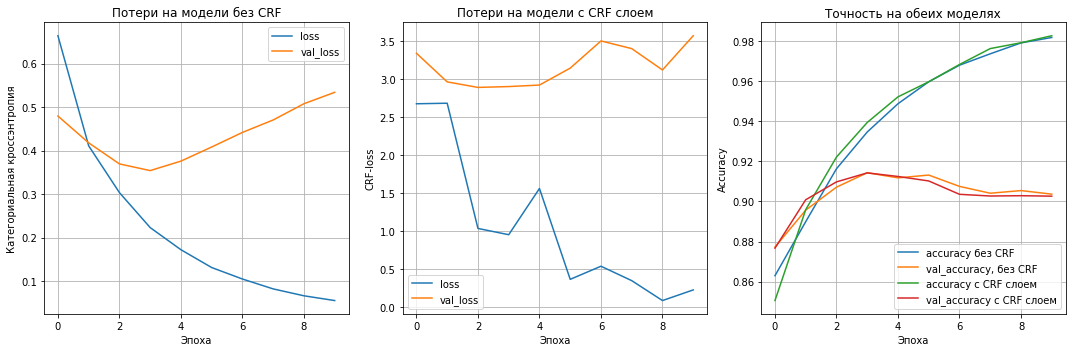

Максимальная точность на обучающей выборке, модель без CRF-слоя: 98.18%
Максимальная точность на обучающей выборке, модель с CRF-слоем: 98.27%
Максимальная точность на валидационной выборке, модель без CRF-слоя: 91.43%
Максимальная точность на валидационной выборке, модель с CRF-слоем: 91.43%


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
no_crf_df[['loss', 'val_loss']].plot(ax=ax[0])
ax[0].set_title('Потери на модели без CRF')
ax[0].set_xlabel('Эпоха')
ax[0].set_ylabel('Категориальная кроссэнтропия')
ax[0].grid()

crf_df[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title('Потери на модели с CRF слоем')
ax[1].set_xlabel('Эпоха')
ax[1].set_ylabel('CRF-loss')
ax[1].grid()


no_crf_df[['accuracy', 'val_accuracy']].plot(ax=ax[2])
crf_df[['accuracy', 'val_accuracy']].plot(ax=ax[2])

labels = [
    'accuracy без CRF', 
    'val_accuracy, без CRF',
    'accuracy с CRF слоем', 
    'val_accuracy с CRF слоем',
]


ax[2].legend(labels)


ax[2].set_title('Точность на обеих моделях')
ax[2].set_xlabel('Эпоха')
ax[2].set_ylabel('Accuracy')
ax[2].grid()
plt.tight_layout()
plt.show()
print('Максимальная точность на обучающей выборке, модель без CRF-слоя: {:.2%}'.format(no_crf_df.accuracy.max()))
print('Максимальная точность на обучающей выборке, модель с CRF-слоем: {:.2%}'.format(crf_df.accuracy.max()))

print('Максимальная точность на валидационной выборке, модель без CRF-слоя: {:.2%}'.format(no_crf_df.val_accuracy.max()))
print('Максимальная точность на валидационной выборке, модель с CRF-слоем: {:.2%}'.format(crf_df.val_accuracy.max()))


### 5. Вывод

- Модель с CRF-слоем обучается в среднем в 3.8 раза дольше, чем модель без CRF-слоя, среднее время обучения одной эпохи составило примерно 115 cекунад против времени обучения эпохи модели без CRF-слоя (в среднем составило 30 секунд)
- Максимальное качество предсказаний обеих моделей оказалось сравнимым  - 97% на обучающей и немного более лучшей на валидационной выборки у модели без RCF-слоя - 90.25% против качества на валидации у модели с  использованием CRF-слоя: 89.88%
- Обе модели склонны к переобучению, на что указывает рост кривых потерь обеих моделей на валидации и снижение точности на валидации обеих моделей против снижения потерь и росте точности на обучающей выборке
- Для данного конкретного датасета использование CRF-слоя в модели видимо не целесообразно.

## Задание Ultra pro

1. Распарсить базу новостей, решить задачу NER

### 1. Подготовка данных

In [ ]:
color_meaning = {'00ff00':'сравнение', '00ffff':'дальность', '9900ff':'эмоции', 
                 'ff00ff':'комфорт', 'ffff00':'скорость',
                'green':'сравнение', 'yellow':'скорость', 'cyan':'дальность', 'magenta':'комфорт'
                }

meaning_token = {'сравнение':0, 'дальность':1, 'эмоции':2, 'комфорт':3, 'скорость':4}
token_meaning = {value:key for key, value in meaning_token.items()}

r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [ ]:
def parse_xml(path, end_i):
    tree = ET.parse(path)
    root = tree.getroot()
    body = root[0]
    ps = list(iter(body))[:end_i]
    
    x = []
    y = []

    for i, paragraph in enumerate(ps):
        phrases_list = paragraph.findall(r)
        text='' 
        labels = [0, 0, 0, 0, 0]
        
        for phrase in phrases_list:
            text += phrase.find(t).text
            style = phrase.find(rpr)
            if style.find(shd) is not None:
                color = style.find(shd).attrib[fill]
            elif style.find(highlight) is not None:
                color = style.find(highlight).attrib[val]
            else:
                color = 'white'
            color = color.lower()
            meaning = color_meaning[color] if color in color_meaning else '' 
            
            if meaning in meaning_token:
                labels[meaning_token[meaning]] = 1
        
        x.append(text)
        y.append(labels)
    
    return x, y

In [ ]:
x1, y1 = parse_xml('/content/Tesla_1.xml', 2497)
x2, y2 = parse_xml('/content/Tesla_2.xml', 2481)
x = x1+x2
y = y1+y2

len(x), len(y)

(2, 2)

In [ ]:
x[0], y[0]

('', [0, 0, 0, 0, 0])

In [ ]:
num_words = 10000
sent_len = 50
tokenizer = Tokenizer(num_words, oov_token='<UNK>')
tokenizer.fit_on_texts(x)
#tokenizer.index_word
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X, sent_len, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1, 50) (1, 5)
(1, 50) (1, 5)


### 2. Балансировка данных

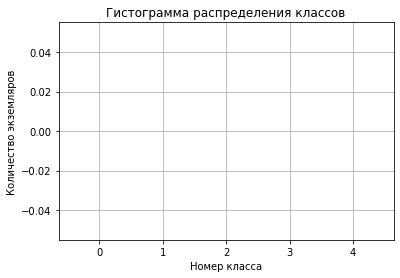

Класс, содержащий максимальное количество значений: 0
Максимальное количесво значений в классе: 0


array([[0, 0, 0, 0, 0]])

In [ ]:
labels_des = y_train.sum(axis=0) 
plt.bar(np.arange(5), labels_des)
plt.grid()
plt.title('Гистограмма распределения классов')
plt.xlabel('Номер класса')
plt.ylabel('Количество экземляров')
plt.show()
max_class = labels_des.argmax()
max_values = labels_des.max()
print('Класс, содержащий максимальное количество значений:', max_class)
print('Максимальное количесво значений в классе:', max_values)
y_train

Посмотрим на распределение чистых классов, будем обучающую выборку добивать ими 

In [ ]:
inds = np.where(y_train.sum(axis=1) == 1)[0]
clear_x = x_train[inds]
clear_y = y_train[inds]
plt.bar(np.arange(5), clear_y.sum(axis=0))
plt.grid()
plt.title('Гистограмма распределения чистых классов')
plt.xlabel('Номер класса')
plt.ylabel('Количество экземляров')
plt.show()
plt.show()

In [ ]:
plsholder = [0,0,0,0,0]
x_new = x_train.copy()
y_new = y_train.copy()

for i in range(5):
    if i == max_class:
        continue
    
    msk = plsholder.copy()
    msk[i] = 1
    idx = np.where((clear_y == msk).all(axis=1))[0]
    sample = np.random.choice(idx, max_values - labels_des[i])
    
    x_new = np.vstack([x_new, clear_x[sample]])
    y_new = np.vstack([y_new, clear_y[sample]])

In [ ]:
labels_des = y_new.sum(axis=0) 
plt.bar(np.arange(5), labels_des)
plt.grid()
plt.title('Гистограмма распределения классов')
plt.xlabel('Номер класса')
plt.ylabel('Количество экземляров')
plt.show()
max_class = labels_des.argmax()
max_values = labels_des.max()
print('Класс, содержащий максимальное количество значений:', max_class)
print('Максимальное количесво значений в классе:', max_values)
y_train

### 3. Модель

In [ ]:
emb_size = 100
hidden_state_1 = 50
hidden_state_2 = 50

inputs = Input((None,))
emb = Embedding(num_words, emb_size)(inputs)
x = SpatialDropout1D(0.2)(emb)
x = BatchNormalization()(x)
x = Bidirectional(GRU(hidden_state_1, return_sequences=True))(x)
x = GRU(hidden_state_2)(x)
output = Dense(5, activation='sigmoid')(x)
model = Model(inputs, output)
model.compile(loss='binary_crossentropy', metrics=['AUC'], optimizer=Adam(lr=1e-4))


history = model.fit(x_new, y_new, 
          validation_data=(x_test, y_test), 
          batch_size=16, 
          epochs=10
         )

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax[0])
ax[0].set_xlabel('Эпоха')
ax[0].set_ylabel('Биннарная кроссэньропия')
ax[0].set_title('Потери')
ax[0].grid()

pd.DataFrame(history.history)[['auc', 'val_auc']].plot(ax=ax[1])
ax[1].set_xlabel('Эпоха')
ax[1].set_ylabel('ROC AUC')
ax[1].set_title('Площадь под кривой AUC')
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_test)

plt.figure(figsize=(10,10))
num_classes = len(meaning_token)

for i in range(num_classes):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label='{} класс - {}, AUC={}'.format(i, token_meaning[i], AUC()(y_test[:, i], y_pred[:, i])))

avg_fpr, avg_tpr, thresholds = roc_curve(y_test.flatten(), y_pred.flatten())
plt.plot(avg_fpr, avg_tpr, label='micro-average, AUC={}'.format(AUC()(y_test, y_pred)))
plt.plot([0,1], [0,1], 'b-.', label='random classifier')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve')

plt.legend()
plt.grid()
plt.show()


In [ ]:
n = 30
print(tokenizer.sequences_to_texts(x_test[n:n+1]))
print((y_pred[n]>=0.5).astype(int))
print(y_test[n])